In [1]:
import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from google_trans_new import google_translator
from lingua import Language, LanguageDetectorBuilder


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Gensim (Word2Vec, Doc2Vec)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, accuracy_score, classification_report, silhouette_score, calinski_harabasz_score, accuracy_score
from sklearn.datasets import load_files
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional
from keras.layers import Embedding
from keras.models import Model, Sequential
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import keras

In [3]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = stopwords.words('english')
    STOPWORDS.remove('not')
    STOPWORDS.remove('is')
    STOPWORDS.remove('but')
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in reviews.split() if word not in STOPWORDS])

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

In [4]:

def clean_text(data):

    data['concat_review'] = data['concat_review'].apply(lower_case)
    data['concat_review'] = data['concat_review'].apply(change_contractions)
    data['concat_review'] = data['concat_review'].apply(remove_emojis)
    data['concat_review'] = data['concat_review'].apply(remove_punctuations)
    data['concat_review'] = data['concat_review'].apply(remove_numbers)
    data['concat_review'] = data['concat_review'].apply(remove_stopwords)
    data['concat_review'] = data['concat_review'].apply(remove_extra_whitespace)
    data['concat_review'] = data['concat_review'].apply(lemmaSentence)
    
    return data

In [5]:
test_df_bryson = pd.read_csv('train_test_dataset/test_df_Bryson.csv')
test_df_kelvin = pd.read_csv('train_test_dataset/test_df_Kelvin.csv')
test_df_Gx =  pd.read_csv('train_test_dataset/test_df_Gx.csv')
df_list = [test_df_bryson, test_df_kelvin, test_df_Gx]
test_df = pd.concat(df_list,ignore_index=True)


In [6]:
test_df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0.2'], inplace = True)
test_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2
0,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1
1,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1
2,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1
3,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1
4,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1
...,...,...,...,...,...,...,...,...,...,...
2325,399226907,5,Perfect Little Board Book,NaN,"I purchased the board book version, which is t...",True,children,Language.ENGLISH,1,1
2326,1542046599,5,Twists and Turns Abound,NaN,"A great suspenseful, ""Who Done It"". I couldn'...",True,mystery,Language.ENGLISH,1,1
2327,B01M0JHBEG,5,we love lift the flaps!,NaN,"This book is a lot of fun for Halloween, with ...",True,children,Language.ENGLISH,1,1
2328,141501596,5,Books ~ the Knowledge Source,NaN,"""June & Jack must read three books before they...",True,children,Language.ENGLISH,1,1


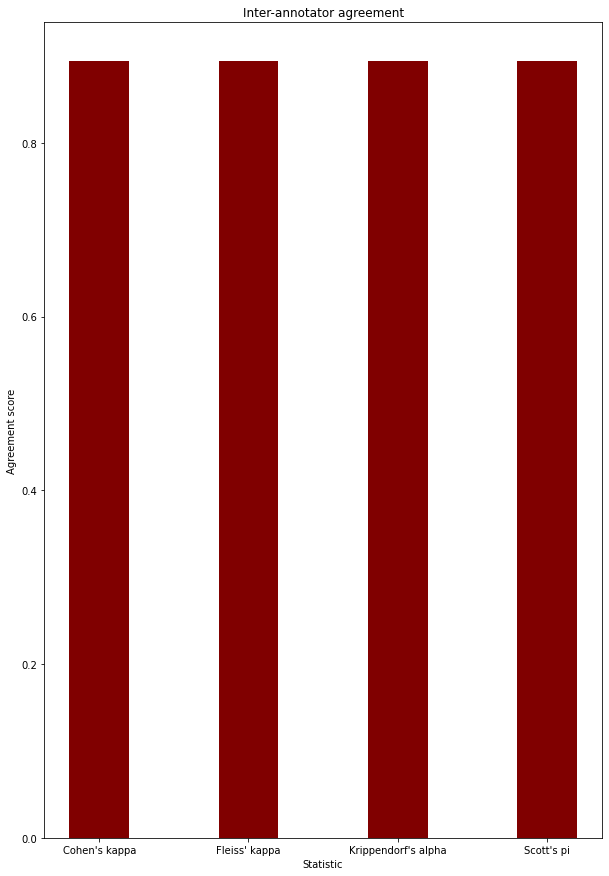

In [7]:
## Interannotator agreement

from nltk import agreement
import matplotlib.pyplot as plt

annotator_1 = test_df["Annotator_1"].to_numpy()
annotator_2 = test_df["Annotator_2"].to_numpy()

taskdata=[[0,str(i),str(annotator_1[i])] for i in range(0,len(annotator_1))]+[[1,str(i),str(annotator_2[i])] for i in range(0,len(annotator_2))]
ratingtask = agreement.AnnotationTask(data=taskdata)

cohen_kappa = ratingtask.kappa()
fleiss_kappa = ratingtask.multi_kappa()
krippendorf_alpha = ratingtask.alpha()
scotts_pi = ratingtask.pi()

scores = {"Cohen's kappa": cohen_kappa, "Fleiss' kappa": fleiss_kappa, "Krippendorf's alpha": krippendorf_alpha, "Scott's pi" : scotts_pi}

statistic = list(scores.keys())
values = list(scores.values())

fig = plt.figure(figsize = (10, 15))
plt.bar(statistic, values, color ='maroon',
        width = 0.4)
plt.xlabel("Statistic")
plt.ylabel("Agreement score")
plt.title("Inter-annotator agreement")
plt.show()

In [8]:
test_df['concat_review'] = test_df['reviewTitle'] + '. ' + test_df['reviewDescription']
test_df = clean_text(test_df)

In [9]:
train_data = pd.read_csv('train_test_dataset/train_df_imbalanced.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20961 entries, 0 to 20960
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         20961 non-null  int64 
 1   productAsin        20961 non-null  object
 2   ratingScore        20961 non-null  int64 
 3   reviewTitle        20960 non-null  object
 4   reviewReaction     5883 non-null   object
 5   reviewDescription  20961 non-null  object
 6   isVerified         20961 non-null  bool  
 7   category           20961 non-null  object
 8   languages          20961 non-null  object
 9   concat_review      20961 non-null  object
 10  polarity           20961 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 1.6+ MB


In [10]:
# Pre-processing of datafame
clean_train_data_df = clean_text(train_data)
clean_train_data_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
0,9406,B08NLXR9V5,4,Girl Alone,One person found this helpful,"My first Blake Pierce book was enjoyable, fast...",True,mystery,Language.ENGLISH,girl alone first blake pierce book enjoyable f...,1
1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,great book young people great story favorite b...,1
2,13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,gripe hype be first book i‚äôve read author th...,-1
3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,add book collection cute educational book teac...,1
4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,okay be one book read couple day story okay,0
...,...,...,...,...,...,...,...,...,...,...,...
20956,12474,1542046599,5,Great read; couldn‚Äôt put it down,NaN,The first chapter reads from an odd point of v...,True,mystery,Language.ENGLISH,great read couldn‚äôt put first chapter read o...,1
20957,22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,use book purchase new receive original replace...,-1
20958,5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,th grader not love book but hard bound be must...,1
20959,891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,one favorite book ever read almost one favorit...,1


In [11]:
# Check if the dataset is balanced
clean_train_data_df["polarity"].value_counts()

 1    13246
-1     7518
 0      197
Name: polarity, dtype: int64

## Balancing train dataset

In [12]:
# Drop the excess positive reviews randomly
differences = clean_train_data_df["polarity"].value_counts()[1]-clean_train_data_df["polarity"].value_counts()[-1]
train_balanced_df = clean_train_data_df.drop(clean_train_data_df[clean_train_data_df["polarity"] == 1].sample(differences,random_state=42).index)
train_balanced_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,great book young people great story favorite b...,1
2,13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,gripe hype be first book i‚äôve read author th...,-1
3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,add book collection cute educational book teac...,1
4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,okay be one book read couple day story okay,0
5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,paperback‚äôs quality suck hate paperback terr...,-1
...,...,...,...,...,...,...,...,...,...,...,...
20951,4658,385376715,5,Awesome book!,NaN,I love this book. I purchased it for a baby sh...,True,children,Language.ENGLISH,awesome book love book purchase baby shower gi...,1
20953,6580,9387779262,4,Good,NaN,Books were smaller than I expected...but still...,True,children,Language.ENGLISH,good book small expectedbut still goodperfect ...,1
20954,23094,194563183X,1,X rated,NaN,I wish I had known how pornographic this book ...,True,children,Language.ENGLISH,x rat wish know pornographic book buy buyer be...,-1
20957,22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,use book purchase new receive original replace...,-1


Text(0, 0.5, 'Frequency')

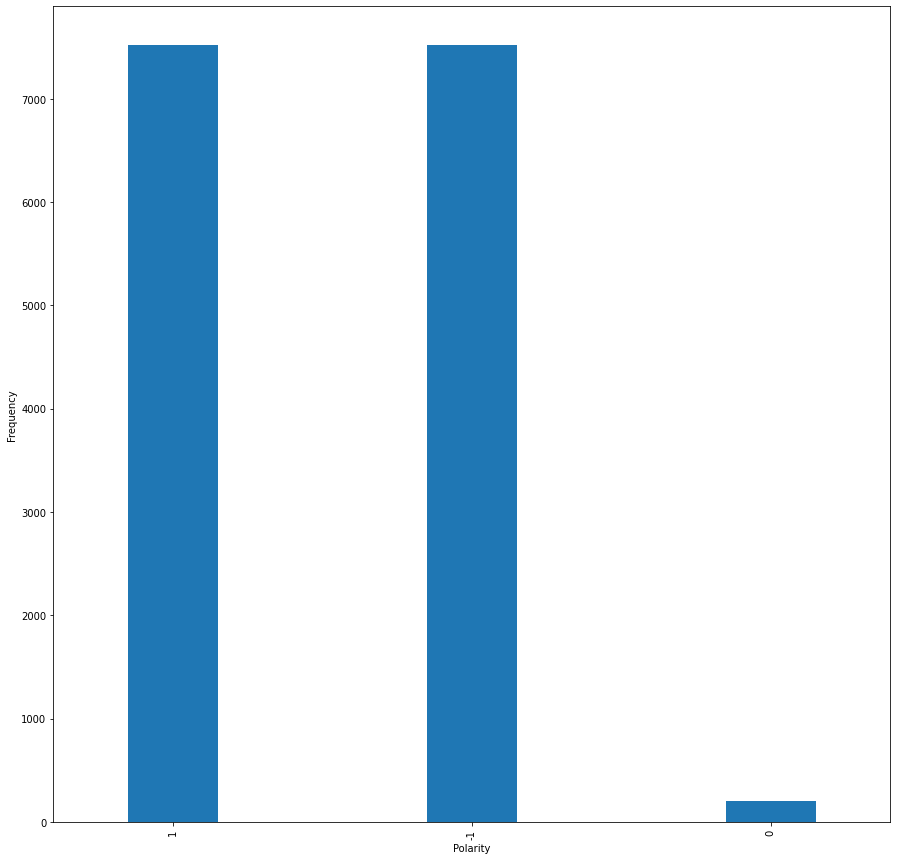

In [13]:
train_balanced_df['polarity'].value_counts(sort=False).plot.bar(figsize=(15,15), width = 0.3)
plt.xlabel('Polarity')
plt.ylabel('Frequency')

#### Visualization

In [14]:
def get_wordcloud(text, color='viridis'):
  # Create a WordCloud object
  
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', colormap=color)
  # Generate a word cloud
  return wordcloud.generate(text)

(-0.5, 399.5, 199.5, -0.5)

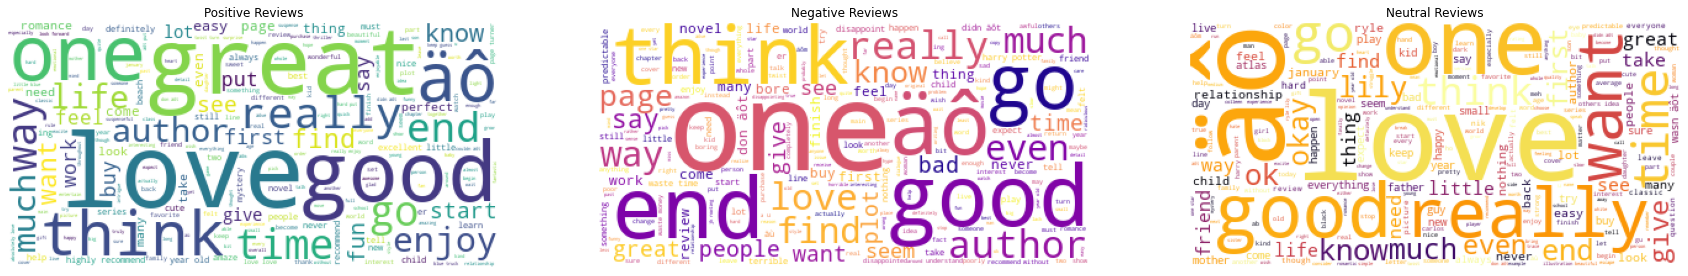

In [15]:
fig, axes =plt.subplots(1,3, figsize=(30,30))

# Wordcloud for positive reviews
pos_reviews = ' '.join(train_balanced_df['concat_review'][train_balanced_df['polarity']==1].values)
words = ['well', 'make', 'book', 'use', 'read', 'write','story', 'character']
for word in words:
  pos_reviews = pos_reviews.replace(word, '')

axes[0].set_title("Positive Reviews")
axes[0].imshow(get_wordcloud(pos_reviews))
axes[0].axis('off')

# Wordcloud for negative reviews
neg_reviews = ' '.join(train_balanced_df['concat_review'][train_balanced_df['polarity']==-1].values)

# Common words
words = ['well', 'make', 'book', 'use', 'read', 'write','story','character']
for word in words:
  neg_reviews = neg_reviews.replace(word, '')

axes[1].set_title("Negative Reviews")
axes[1].imshow(get_wordcloud(neg_reviews,'plasma'))
axes[1].axis('off')

# Wordcloud for neutral reviews
neutral_reviews = ' '.join(train_balanced_df['concat_review'][train_balanced_df['polarity']==0].values)
words = ['well', 'make', 'book', 'use', 'read', 'write','story','character']
for word in words:
  neutral_reviews = neutral_reviews.replace(word, '')

axes[2].set_title("Neutral Reviews")
axes[2].imshow(get_wordcloud(neutral_reviews, 'inferno'))
axes[2].axis('off')




## Modelling

In [16]:

X = train_balanced_df["concat_review"].values
Y = train_balanced_df['polarity'].values


unseen_X_test = test_df['concat_review'].values
unseen_Y_test = test_df['Annotator_1'].values

In [17]:
# Train and test split 
# 80 train 20 test split
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_lstm_train = pd.get_dummies(Y_train)
y_lstm_test = pd.get_dummies(y_test)

#### Different methods of vectorizing text

**Tf-Idf**

In [18]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer=word_tokenize)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
x_test_tfidf = tfidf_vect.transform(x_test)
unseen_X_test_tfidf = tfidf_vect.transform(unseen_X_test)

Word2Vec - Averaged vector

Link: https://rare-technologies.com/word2vec-tutorial/


In [19]:
# Tokenization
X_train_tok = [word_tokenize(sentence) for sentence in X_train]
x_test_tok = [word_tokenize(sentence) for sentence in x_test]

unseen_X_test_tok = [word_tokenize(sentence) for sentence in unseen_X_test]

In [20]:
# Word2Vec model
model_word2vec = Word2Vec(min_count=2,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)



In [21]:
# Building vocabulary
model_word2vec.build_vocab(X_train_tok)

In [22]:
# Training model
model_word2vec.train(X_train_tok, total_examples=model_word2vec.corpus_count, epochs=30, report_delay=1)
model_word2vec.save("model/word2vec.model")

In [23]:
model_word2vec = gensim.models.word2vec.Word2Vec.load("model/word2vec.model")

In [24]:
# Compute mean vector given the word2vec vector for every word in a document
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) >= 1:
        return model.wv.get_mean_vector(words)
    else:
        return np.zeros(300)

In [25]:
# Get the mean vector
X_train_Word2Vec = [get_mean_vector(model_word2vec, review) for review in X_train_tok]
x_test_Word2Vec = [get_mean_vector(model_word2vec, review) for review in x_test_tok]

unseen_X_test_Word2Vec = [get_mean_vector(model_word2vec, review) for review in unseen_X_test_tok]


In [26]:
# Scaling values between 0 and 1
# Gotta investigate if it affects -1(negative) but MultinomialNB dont accept neg values so abit sus

scaler_Word2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Word2Vec = scaler_Word2Vec.fit_transform(X_train_Word2Vec)
x_test_Word2Vec = scaler_Word2Vec.transform(x_test_Word2Vec)

unseen_X_test_Word2Vec = scaler_Word2Vec.transform(unseen_X_test_Word2Vec)


## Doc2Vec

In [27]:
# Tag all the documents
tagged_data = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(X_train_tok)]

In [28]:
# Building of the Doc2Vec model
model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, epochs=10)
model_doc2vec.build_vocab(tagged_data)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)


In [29]:
model_doc2vec.save("model/doc2vec.model")


In [30]:
model_doc2vec = gensim.models.doc2vec.Doc2Vec.load("model/doc2vec.model")

In [31]:
# Get the vectors for every document
X_train_Doc2Vec = model_doc2vec.dv.vectors
x_test_Doc2Vec = [model_doc2vec.infer_vector(doc) for doc in x_test_tok]
unseen_X_test_Doc2Vec = [model_doc2vec.infer_vector(doc) for doc in unseen_X_test_tok]


In [32]:
# Scaling values between 0 and 1
scaler_Doc2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Doc2Vec = scaler_Doc2Vec.fit_transform(X_train_Doc2Vec)
x_test_Doc2Vec = scaler_Doc2Vec.transform(x_test_Doc2Vec)
unseen_X_test_Doc2Vec = scaler_Doc2Vec.transform(unseen_X_test_Doc2Vec)


In [33]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: -1','Predicted: 0','Predicted: 1'],
                                         index=['Actual: -1','Actual: 0','Actual: 1'])
                                                        
    plt.figure(figsize = (10,5))
    sn.set(font_scale=1.2)
    sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.title(f"Confusion Matrix for Sentiment Analysis using {model_name}")
    plt.yticks(rotation=360)
    plt.show()

    print(f"Confusion Matrix for Sentiment Analysis using {model_name}:",accuracy_score(y_true, y_pred))
    print("-"*100)
    print(f"Classification Report for Sentiment Analysis using {model_name}:\n\n",classification_report(y_true, y_pred))
    print("-"*100)
    Negative = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])*100
    print("Negative has a accuracy of {} %".format(Negative))
    print()
    Neutral = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])*100
    print("Neutral has a accuracy of {} %".format(Neutral))
    print()
    Positive = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])*100
    print("Positive has a accuracy of {} %".format(Positive))

In [34]:
# unseen_lstm_Y_test = pd.get_dummies(unseen_Y_test)
# sequences_test = tokenizer.texts_to_sequences(unseen_X_test)
# unseen_X_test = pad_sequences(sequences_test, maxlen=1000)
# pred = model.predict(unseen_X_test)
# # help function to obtain true_pred

# y_true, y_pred = get_true_pred(pred, unseen_lstm_Y_test.values)
# print(unseen_lstm_Y_test)
# plot_confusion_matrix(y_true, y_pred, "LSTM")

## Traditional Machine Learning Models

Naive Bayes

In [35]:
def naive_bayes_model(x_train, y_train):
    # Naive bayes
    naive_bayes_mod = MultinomialNB()
    naive_bayes_mod.fit(x_train, y_train)
    

    return naive_bayes_mod


Linear SVC

In [36]:
# Support vector machine
def Linear_SVC_model(X_train, Y_train):
    Linear_SVC_mod = LinearSVC(max_iter=3000)
    Linear_SVC_mod.fit(X_train, Y_train)

    return Linear_SVC_mod


Logistic Regression

In [37]:
# Logistic regression
def LogisticRegression_model(X_train, Y_train):
    Logistic_Regression_mod = LogisticRegression(max_iter=3000)
    Logistic_Regression_mod.fit(X_train, Y_train)

    return Logistic_Regression_mod

## Tf-Idf

In [38]:
naive_bayes_tfidf = naive_bayes_model(X_train_tfidf, Y_train)
Linear_SVC_tfidf = Linear_SVC_model(X_train_tfidf, Y_train)
Logistic_Regression_tfidf = LogisticRegression_model(X_train_tfidf, Y_train)

In [39]:
naive_bayes_tfidf_prediction = naive_bayes_tfidf.predict(x_test_tfidf)
Linear_SVC_tfidf_prediction = Linear_SVC_tfidf.predict(x_test_tfidf)
Logistic_Regression_tfidf_prediction = Logistic_Regression_tfidf.predict(x_test_tfidf)

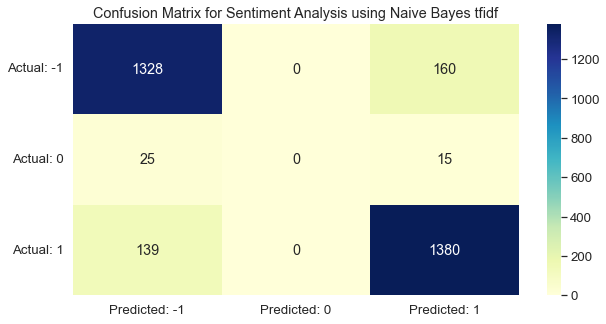

Confusion Matrix for Sentiment Analysis using Naive Bayes tfidf: 0.8887430259271415
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes tfidf:

               precision    recall  f1-score   support

          -1       0.89      0.89      0.89      1488
           0       0.00      0.00      0.00        40
           1       0.89      0.91      0.90      1519

    accuracy                           0.89      3047
   macro avg       0.59      0.60      0.60      3047
weighted avg       0.88      0.89      0.88      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 89.24731182795699 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 90.84924292297563 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

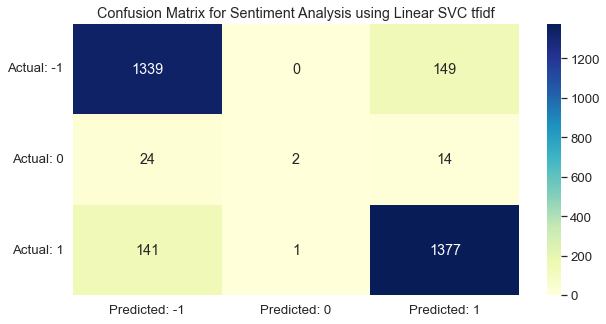

Confusion Matrix for Sentiment Analysis using Linear SVC tfidf: 0.8920249425664588
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC tfidf:

               precision    recall  f1-score   support

          -1       0.89      0.90      0.90      1488
           0       0.67      0.05      0.09        40
           1       0.89      0.91      0.90      1519

    accuracy                           0.89      3047
   macro avg       0.82      0.62      0.63      3047
weighted avg       0.89      0.89      0.89      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 89.98655913978494 %

Neutral has a accuracy of 5.0 %

Positive has a accuracy of 90.65174456879525 %


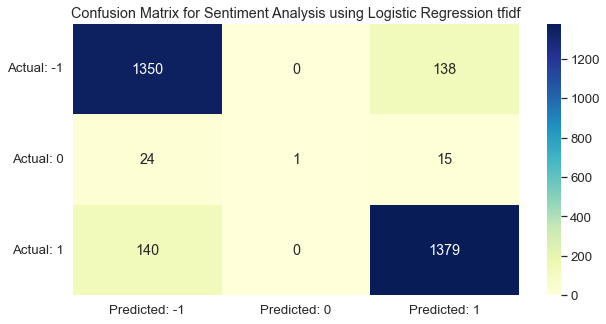

Confusion Matrix for Sentiment Analysis using Logistic Regression tfidf: 0.8959632425336397
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression tfidf:

               precision    recall  f1-score   support

          -1       0.89      0.91      0.90      1488
           0       1.00      0.03      0.05        40
           1       0.90      0.91      0.90      1519

    accuracy                           0.90      3047
   macro avg       0.93      0.61      0.62      3047
weighted avg       0.90      0.90      0.89      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 90.7258064516129 %

Neutral has a accuracy of 2.5 %

Positive has a accuracy of 90.78341013824884 %


In [40]:
plot_confusion_matrix(y_test, naive_bayes_tfidf_prediction, "Naive Bayes tfidf")
plot_confusion_matrix(y_test,  Linear_SVC_tfidf_prediction, "Linear SVC tfidf")
plot_confusion_matrix(y_test,  Logistic_Regression_tfidf_prediction, "Logistic Regression tfidf")

In [41]:
unseen_naive_bayes_tfidf_prediction = naive_bayes_tfidf.predict(unseen_X_test_tfidf)
unseen_Linear_SVC_tfidf_prediction = Linear_SVC_tfidf.predict(unseen_X_test_tfidf)
unseen_Logistic_Regression_tfidf_prediction = Logistic_Regression_tfidf.predict(unseen_X_test_tfidf)


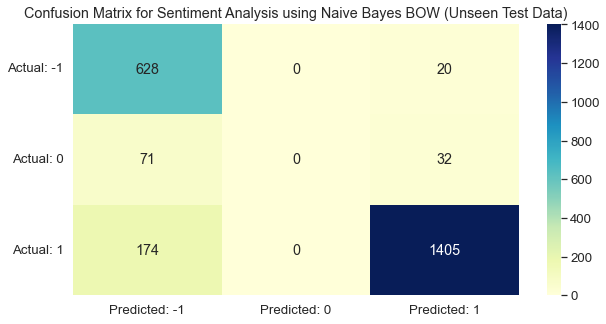

Confusion Matrix for Sentiment Analysis using Naive Bayes BOW (Unseen Test Data): 0.8725321888412018
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes BOW (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.72      0.97      0.83       648
           0       0.00      0.00      0.00       103
           1       0.96      0.89      0.93      1579

    accuracy                           0.87      2330
   macro avg       0.56      0.62      0.58      2330
weighted avg       0.85      0.87      0.86      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 96.91358024691358 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 88.98036732108929 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

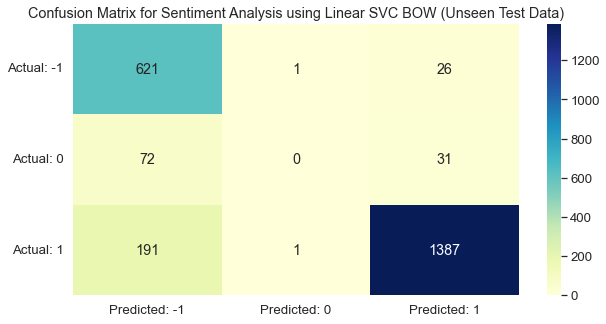

Confusion Matrix for Sentiment Analysis using Linear SVC BOW (Unseen Test Data): 0.8618025751072962
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC BOW (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.70      0.96      0.81       648
           0       0.00      0.00      0.00       103
           1       0.96      0.88      0.92      1579

    accuracy                           0.86      2330
   macro avg       0.55      0.61      0.58      2330
weighted avg       0.85      0.86      0.85      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 95.83333333333334 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 87.84040531982266 %


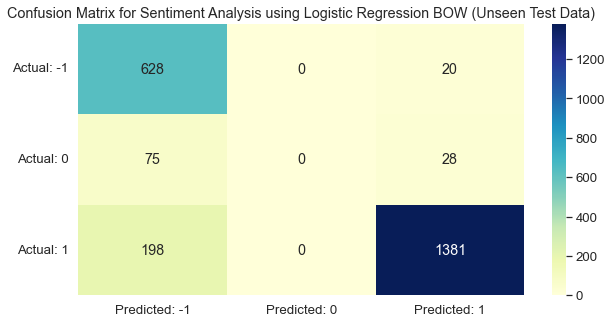

Confusion Matrix for Sentiment Analysis using Logistic Regression BOW (Unseen Test Data): 0.8622317596566523
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression BOW (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.70      0.97      0.81       648
           0       0.00      0.00      0.00       103
           1       0.97      0.87      0.92      1579

    accuracy                           0.86      2330
   macro avg       0.55      0.61      0.58      2330
weighted avg       0.85      0.86      0.85      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 96.91358024691358 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 87.46041798606713 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [42]:
plot_confusion_matrix(unseen_Y_test, unseen_naive_bayes_tfidf_prediction, "Naive Bayes BOW (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Linear_SVC_tfidf_prediction, "Linear SVC BOW (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Logistic_Regression_tfidf_prediction, "Logistic Regression BOW (Unseen Test Data)")

In [43]:
from sklearn import metrics

print("MultinomialNB Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, naive_bayes_tfidf_prediction))
print("Unseen MultinomialNB Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(unseen_Y_test,  unseen_naive_bayes_tfidf_prediction))
naive_bayes_tfidf_score = metrics.accuracy_score(y_test, naive_bayes_tfidf_prediction)
unseen_naive_bayes_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_tfidf_prediction)

print("Linear SVC Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, Linear_SVC_tfidf_prediction))
print("Unseen Linear SVC Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_tfidf_prediction))
Linear_SVC_tfidf_score = metrics.accuracy_score(y_test, Linear_SVC_tfidf_prediction)
unseen_Linear_SVC_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_tfidf_prediction)

print("Logistic Regression Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, Logistic_Regression_tfidf_prediction))
print("Unseen_Logistic Regression Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_tfidf_prediction))
Logistic_Regression_tfidf_score = metrics.accuracy_score(y_test, Logistic_Regression_tfidf_prediction)
unseen_Logistic_Regression_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_tfidf_prediction)

tfidf_score_list = [naive_bayes_tfidf_score, Linear_SVC_tfidf_score, Logistic_Regression_tfidf]
tfidf_unseen_score_lsit = [unseen_naive_bayes_tfidf_score, unseen_Linear_SVC_tfidf_score, unseen_Linear_SVC_tfidf_score]



MultinomialNB Accuracy for Bag of words TF-IDF: 0.8887430259271415
Unseen MultinomialNB Accuracy for Bag of words TF-IDF: 0.8725321888412018
Linear SVC Accuracy for Bag of words TF-IDF: 0.8920249425664588
Unseen Linear SVC Accuracy for Bag of words TF-IDF: 0.8618025751072962
Logistic Regression Accuracy for Bag of words TF-IDF: 0.8959632425336397
Unseen_Logistic Regression Accuracy for Bag of words TF-IDF: 0.8622317596566523


## Word2Vec - Averaged vector

In [44]:
naive_bayes_Word2Vec = naive_bayes_model(X_train_Word2Vec, Y_train)
# Support vector machine
Linear_SVC_Word2Vec = Linear_SVC_model(X_train_Word2Vec, Y_train)
# Logistic regression
Logistic_Regression_Word2Vec = LogisticRegression_model(X_train_Word2Vec, Y_train)


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
naive_bayes_Word2Vec_prediction = naive_bayes_Word2Vec.predict(x_test_Word2Vec)
Linear_SVC_Word2Vec_prediction = Linear_SVC_Word2Vec.predict(x_test_Word2Vec)
Logistic_Regression_Word2Vec_prediction = Logistic_Regression_Word2Vec.predict(x_test_Word2Vec)

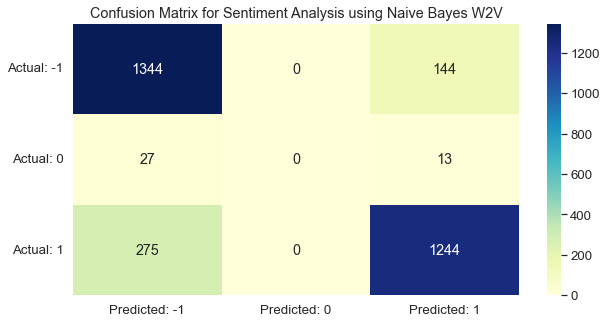

Confusion Matrix for Sentiment Analysis using Naive Bayes W2V: 0.8493600262553331
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes W2V:

               precision    recall  f1-score   support

          -1       0.82      0.90      0.86      1488
           0       0.00      0.00      0.00        40
           1       0.89      0.82      0.85      1519

    accuracy                           0.85      3047
   macro avg       0.57      0.57      0.57      3047
weighted avg       0.84      0.85      0.84      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 90.32258064516128 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 81.89598420013166 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

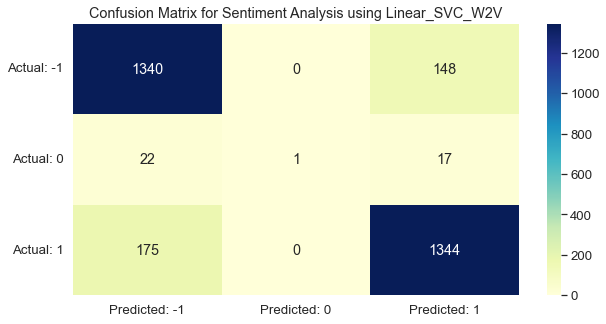

Confusion Matrix for Sentiment Analysis using Linear_SVC_W2V: 0.8811946176567115
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear_SVC_W2V:

               precision    recall  f1-score   support

          -1       0.87      0.90      0.89      1488
           0       1.00      0.03      0.05        40
           1       0.89      0.88      0.89      1519

    accuracy                           0.88      3047
   macro avg       0.92      0.60      0.61      3047
weighted avg       0.88      0.88      0.88      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 90.05376344086021 %

Neutral has a accuracy of 2.5 %

Positive has a accuracy of 88.47926267281106 %


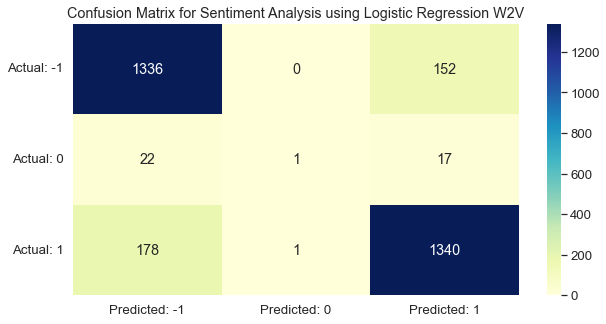

Confusion Matrix for Sentiment Analysis using Logistic Regression W2V: 0.8785690843452576
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression W2V:

               precision    recall  f1-score   support

          -1       0.87      0.90      0.88      1488
           0       0.50      0.03      0.05        40
           1       0.89      0.88      0.89      1519

    accuracy                           0.88      3047
   macro avg       0.75      0.60      0.61      3047
weighted avg       0.87      0.88      0.87      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 89.78494623655914 %

Neutral has a accuracy of 2.5 %

Positive has a accuracy of 88.21593153390388 %


In [46]:
plot_confusion_matrix(y_test,  naive_bayes_Word2Vec_prediction, "Naive Bayes W2V")
plot_confusion_matrix(y_test,  Linear_SVC_Word2Vec_prediction, "Linear_SVC_W2V")
plot_confusion_matrix(y_test,  Logistic_Regression_Word2Vec_prediction, "Logistic Regression W2V")

In [47]:
unseen_naive_bayes_Word2Vec_prediction = naive_bayes_Word2Vec.predict(unseen_X_test_Word2Vec)
unseen_Linear_SVC_Word2Vec_prediction = Linear_SVC_Word2Vec.predict(unseen_X_test_Word2Vec)
unseen_Logistic_Regression_Word2Vec_prediction = Logistic_Regression_Word2Vec.predict(unseen_X_test_Word2Vec)

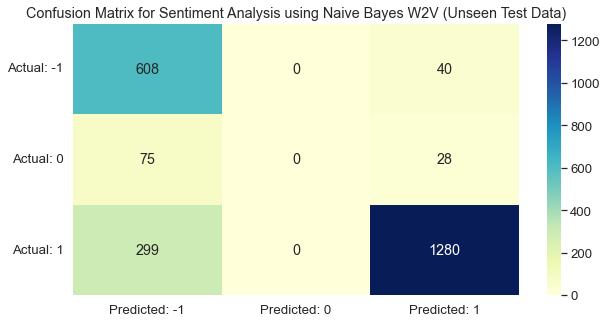

Confusion Matrix for Sentiment Analysis using Naive Bayes W2V (Unseen Test Data): 0.8103004291845494
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes W2V (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.62      0.94      0.75       648
           0       0.00      0.00      0.00       103
           1       0.95      0.81      0.87      1579

    accuracy                           0.81      2330
   macro avg       0.52      0.58      0.54      2330
weighted avg       0.82      0.81      0.80      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 93.82716049382715 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 81.06396453451552 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

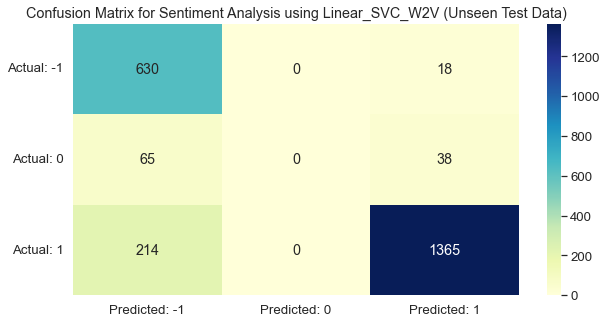

Confusion Matrix for Sentiment Analysis using Linear_SVC_W2V (Unseen Test Data): 0.8562231759656652
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear_SVC_W2V (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.69      0.97      0.81       648
           0       0.00      0.00      0.00       103
           1       0.96      0.86      0.91      1579

    accuracy                           0.86      2330
   macro avg       0.55      0.61      0.57      2330
weighted avg       0.84      0.86      0.84      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 97.22222222222221 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 86.44711842938568 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

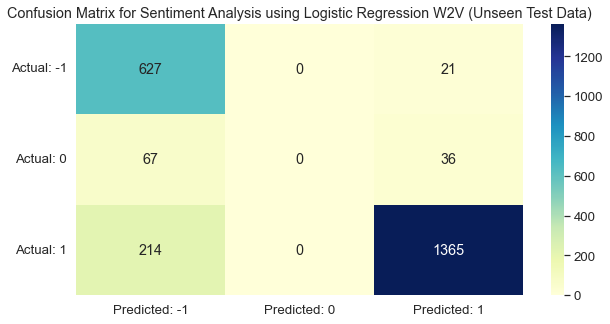

Confusion Matrix for Sentiment Analysis using Logistic Regression W2V (Unseen Test Data): 0.8549356223175966
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression W2V (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.69      0.97      0.81       648
           0       0.00      0.00      0.00       103
           1       0.96      0.86      0.91      1579

    accuracy                           0.85      2330
   macro avg       0.55      0.61      0.57      2330
weighted avg       0.84      0.85      0.84      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 96.75925925925925 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 86.44711842938568 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [48]:
plot_confusion_matrix(unseen_Y_test,  unseen_naive_bayes_Word2Vec_prediction, "Naive Bayes W2V (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Linear_SVC_Word2Vec_prediction, "Linear_SVC_W2V (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Logistic_Regression_Word2Vec_prediction, "Logistic Regression W2V (Unseen Test Data)")

In [49]:
print("MultinomialNB Accuracy for Word2Vec:",metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction))
print("Unseen MultinomialNB Accuracy for Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Word2Vec_prediction))
naive_bayes_Word2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction)
unseen_naive_bayes_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Word2Vec_prediction)

print("Linear SVC Accuracy for Linear_SVC_Word2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction))
print("unseen Linear SVC Accuracy for Linear_SVC_Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Word2Vec_prediction))
Linear_SVC_Word2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction)
unseen_Linear_SVC_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Word2Vec_prediction)

print("Logistic Regression Accuracy for Logistic_Regression_Word2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction))
print("Unseen Logistic Regression Accuracy for Logistic_Regression_Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Word2Vec_prediction))
Logistic_Regression_Word2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction)
unseen_Logistic_Regression_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Word2Vec_prediction)

W2V_score_list = [naive_bayes_Word2Vec_score, Linear_SVC_Word2Vec_score, Logistic_Regression_Word2Vec_score]
unseen_W2V_score_list = [unseen_naive_bayes_Word2Vec_score, unseen_Linear_SVC_Word2Vec_score, unseen_Logistic_Regression_Word2Vec_score]

MultinomialNB Accuracy for Word2Vec: 0.8493600262553331
Unseen MultinomialNB Accuracy for Word2Vec: 0.8103004291845494
Linear SVC Accuracy for Linear_SVC_Word2Vec: 0.8811946176567115
unseen Linear SVC Accuracy for Linear_SVC_Word2Vec: 0.8562231759656652
Logistic Regression Accuracy for Logistic_Regression_Word2Vec: 0.8785690843452576
Unseen Logistic Regression Accuracy for Logistic_Regression_Word2Vec: 0.8549356223175966


## Doc2Vec

In [50]:
naive_bayes_Doc2Vec = naive_bayes_model(X_train_Doc2Vec, Y_train)
# Support vector machine
Linear_SVC_Doc2Vec = Linear_SVC_model(X_train_Doc2Vec, Y_train)
Logistic_Regression_Doc2Vec= LogisticRegression_model(X_train_Doc2Vec, Y_train)


In [51]:
naive_bayes_Doc2Vec_prediction = naive_bayes_Doc2Vec.predict(x_test_Doc2Vec)
Linear_SVC_Doc2Vec_prediction = Linear_SVC_Doc2Vec.predict(x_test_Doc2Vec)
Logistic_Regression_Doc2Vec_prediction = Logistic_Regression_Doc2Vec.predict(x_test_Doc2Vec)

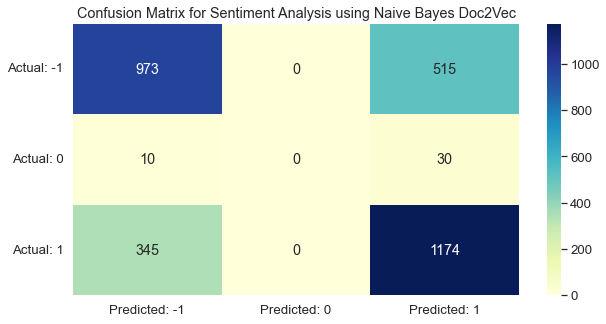

Confusion Matrix for Sentiment Analysis using Naive Bayes Doc2Vec: 0.7046275024614375
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes Doc2Vec:

               precision    recall  f1-score   support

          -1       0.73      0.65      0.69      1488
           0       0.00      0.00      0.00        40
           1       0.68      0.77      0.73      1519

    accuracy                           0.70      3047
   macro avg       0.47      0.48      0.47      3047
weighted avg       0.70      0.70      0.70      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 65.38978494623656 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 77.28768926925609 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

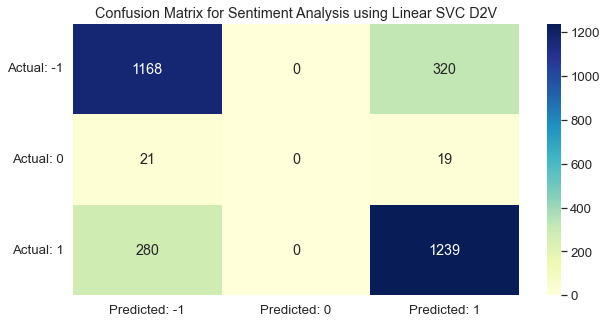

Confusion Matrix for Sentiment Analysis using Linear SVC D2V: 0.7899573350836889
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC D2V:

               precision    recall  f1-score   support

          -1       0.80      0.78      0.79      1488
           0       0.00      0.00      0.00        40
           1       0.79      0.82      0.80      1519

    accuracy                           0.79      3047
   macro avg       0.53      0.53      0.53      3047
weighted avg       0.78      0.79      0.78      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 78.49462365591397 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 81.5668202764977 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

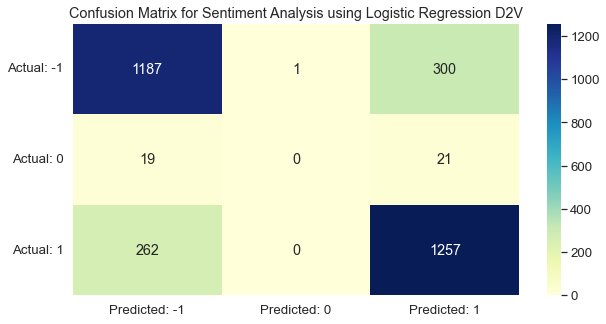

Confusion Matrix for Sentiment Analysis using Logistic Regression D2V: 0.8021004266491631
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression D2V:

               precision    recall  f1-score   support

          -1       0.81      0.80      0.80      1488
           0       0.00      0.00      0.00        40
           1       0.80      0.83      0.81      1519

    accuracy                           0.80      3047
   macro avg       0.54      0.54      0.54      3047
weighted avg       0.79      0.80      0.80      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 79.77150537634408 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 82.75181040157999 %


In [52]:
plot_confusion_matrix(y_test,  naive_bayes_Doc2Vec_prediction, "Naive Bayes Doc2Vec")
plot_confusion_matrix(y_test, Linear_SVC_Doc2Vec_prediction, "Linear SVC D2V")
plot_confusion_matrix(y_test,  Logistic_Regression_Doc2Vec_prediction, "Logistic Regression D2V")


In [53]:
unseen_naive_bayes_Doc2Vec_prediction = naive_bayes_Doc2Vec.predict(unseen_X_test_Doc2Vec)
unseen_Linear_SVC_Doc2Vec_prediction = Linear_SVC_Doc2Vec.predict(unseen_X_test_Doc2Vec)
unseen_Logistic_Regression_Doc2Vec_prediction = Logistic_Regression_Doc2Vec.predict(unseen_X_test_Doc2Vec)

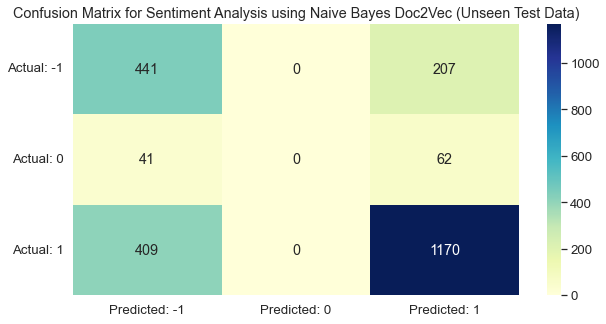

Confusion Matrix for Sentiment Analysis using Naive Bayes Doc2Vec (Unseen Test Data): 0.6914163090128755
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes Doc2Vec (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.49      0.68      0.57       648
           0       0.00      0.00      0.00       103
           1       0.81      0.74      0.78      1579

    accuracy                           0.69      2330
   macro avg       0.44      0.47      0.45      2330
weighted avg       0.69      0.69      0.68      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 68.05555555555556 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 74.0975300823306 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

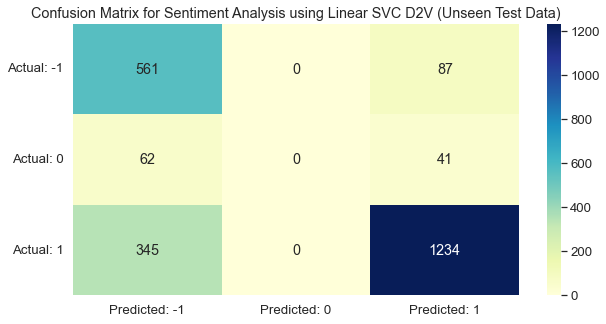

Confusion Matrix for Sentiment Analysis using Linear SVC D2V (Unseen Test Data): 0.7703862660944206
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC D2V (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.58      0.87      0.69       648
           0       0.00      0.00      0.00       103
           1       0.91      0.78      0.84      1579

    accuracy                           0.77      2330
   macro avg       0.50      0.55      0.51      2330
weighted avg       0.78      0.77      0.76      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 86.57407407407408 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 78.15072830905636 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

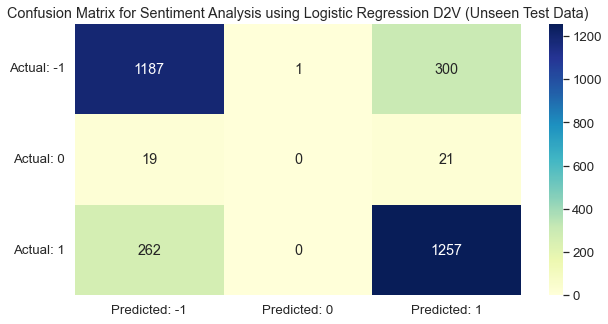

Confusion Matrix for Sentiment Analysis using Logistic Regression D2V (Unseen Test Data): 0.8021004266491631
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression D2V (Unseen Test Data):

               precision    recall  f1-score   support

          -1       0.81      0.80      0.80      1488
           0       0.00      0.00      0.00        40
           1       0.80      0.83      0.81      1519

    accuracy                           0.80      3047
   macro avg       0.54      0.54      0.54      3047
weighted avg       0.79      0.80      0.80      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 79.77150537634408 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 82.75181040157999 %


In [54]:
plot_confusion_matrix(unseen_Y_test,  unseen_naive_bayes_Doc2Vec_prediction, "Naive Bayes Doc2Vec (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction, "Linear SVC D2V (Unseen Test Data)")
plot_confusion_matrix(y_test,  Logistic_Regression_Doc2Vec_prediction, "Logistic Regression D2V (Unseen Test Data)")

In [55]:
print("MultinomialNB Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction))
print("Unseen MultinomialNB Accuracy for Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Doc2Vec_prediction))
naive_bayes_Doc2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction)
unseen_naive_bayes_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Doc2Vec_prediction)

print("Linear_SVC Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction))
print("Unseen Linear_SVC Accuracy for Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction))
Linear_SVC_Doc2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction)
unseen_Linear_SVC_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction)

print("Logistic Regression Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction))
print("Unseen Logistic Regression Accuracy for Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Doc2Vec_prediction))
Logistic_Regression_Doc2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction)
unseen_Logistic_Regression_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Doc2Vec_prediction)

D2V_score_list = [naive_bayes_Doc2Vec_score, Linear_SVC_Doc2Vec_score, Logistic_Regression_Doc2Vec_score]
unseen_D2V_score_list = [unseen_naive_bayes_Doc2Vec_score, unseen_Linear_SVC_Doc2Vec_score, unseen_Logistic_Regression_Doc2Vec_score]

MultinomialNB Accuracy for Doc2Vec: 0.7046275024614375
Unseen MultinomialNB Accuracy for Doc2Vec: 0.6914163090128755
Linear_SVC Accuracy for Doc2Vec: 0.7899573350836889
Unseen Linear_SVC Accuracy for Doc2Vec: 0.7703862660944206
Logistic Regression Accuracy for Doc2Vec: 0.8021004266491631
Unseen Logistic Regression Accuracy for Doc2Vec: 0.7815450643776825


## LSTM Neural Network

In [56]:
def model_architecture(emb_layer):
  
    # Creating a LSTM Model 
    # Dropout is use to prevent the model from overfitting
    LSTM_model = Sequential()
    LSTM_model.add(emb_layer)
    LSTM_model.add(Dropout(0.5))
    LSTM_model.add(CuDNNLSTM(100))
    LSTM_model.add(Dense(3, activation='softmax'))
    LSTM_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return LSTM_model
    
def get_true_pred(predictions, y_test):
    neg_count, neu_count, pos_count = 0, 0, 0
    real_neg, real_neu, real_pos = 0, 0, 0

    y_pred = []
    y_true = []

    for i, prediction in enumerate(predictions):
        print(i)
        print(prediction)
        if np.argmax(prediction) == 0:
            neg_count += 1
        elif np.argmax(prediction) == 1:
            neu_count += 1
        else:
            pos_count += 1

        y_pred.append(np.argmax(prediction))

        if np.argmax(y_test[i]) == 0:
            real_neg += 1
        elif np.argmax(y_test[i]) == 1:    
            real_neu += 1
        else:
            real_pos +=1

        y_true.append(np.argmax(y_test[i]))

    print('Negative predictions:', neg_count)
    print('Neutral predictions:', neu_count)
    print('Positive predictions:', pos_count)
    print('True negative:', real_neg)
    print('True neutral:', real_neu)
    print('True positive:', real_pos)
    
    return y_true, y_pred

from keras.callbacks import ReduceLROnPlateau
early_stopping = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

#### Looked online, seems like TF-IDF vectorizer output is not suitable for keras model. 

## Word2Vec

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_w2v_seq = tokenizer.texts_to_sequences(X_train)
words_to_index = tokenizer.word_index
vocab_size = len(words_to_index)+1

#We define maxLen which is the maximum length of one review we will use for our training, 
# Try 1000 
maxLen = 1000

#  we will pad the sequences so all of them have the same length.
X_train_seq = pad_sequences(X_train_w2v_seq, maxlen=maxLen)
x_test_indices = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(x_test_indices, maxlen=maxLen)

In [58]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in model_word2vec.wv:
        embedding_matrix[i] = model_word2vec.wv[word]
print(embedding_matrix.shape)

(23149, 300)


In [59]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=1000)

In [60]:
w2v_lstm_model = model_architecture(w2v_embedding_layer)
w2v_lstm_model.fit(X_train_seq, Y_lstm_train,
                batch_size=32,
                epochs=10,
                validation_data=(x_test_indices, y_lstm_test),
                verbose=1,
                callbacks=early_stopping)

Epoch 1/10
381/381 [==============================] - 35s 85ms/step - loss: 0.3594 - accuracy: 0.8688 - val_loss: 0.3165 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 2/10
381/381 [==============================] - 32s 83ms/step - loss: 0.2752 - accuracy: 0.9001 - val_loss: 0.3272 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 3/10
381/381 [==============================] - 32s 83ms/step - loss: 0.2243 - accuracy: 0.9212 - val_loss: 0.2863 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 4/10
381/381 [==============================] - 32s 83ms/step - loss: 0.1754 - accuracy: 0.9413 - val_loss: 0.3053 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 5/10
381/381 [==============================] - 32s 83ms/step - loss: 0.1248 - accuracy: 0.9576 - val_loss: 0.3283 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 6/10
381/381 [==============================] - 33s 87ms/step - loss: 0.0834 - accuracy: 0.9710 - val_loss: 0.4089 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 7/10
381/381 [==============================] - 37s 

73/73 [==============================] - 3s 37ms/step
0
[9.9999154e-01 9.2134684e-07 7.5133225e-06]
1
[9.9849534e-01 6.7529711e-04 8.2942250e-04]
2
[9.9999535e-01 4.1939029e-06 4.7517503e-07]
3
[0.02811973 0.08026615 0.89161414]
4
[9.914129e-01 8.021904e-03 5.652575e-04]
5
[9.9999940e-01 1.5101517e-07 4.7542991e-07]
6
[9.9749964e-01 9.6784567e-04 1.5325253e-03]
7
[9.9997830e-01 1.8212693e-05 3.5100306e-06]
8
[9.9989343e-01 9.4473005e-05 1.2015271e-05]
9
[9.9999201e-01 1.4719254e-06 6.5090790e-06]
10
[9.9972683e-01 2.4784982e-05 2.4833047e-04]
11
[9.9997818e-01 5.6295912e-06 1.6180731e-05]
12
[9.9982941e-01 1.4080704e-04 2.9755214e-05]
13
[9.9995863e-01 3.5624842e-05 5.6809749e-06]
14
[9.9996984e-01 1.5419208e-05 1.4812719e-05]
15
[9.9999821e-01 1.3929791e-06 3.0656736e-07]
16
[0.98386097 0.00115884 0.01498017]
17
[9.9997950e-01 8.5994670e-06 1.1969344e-05]
18
[9.9999785e-01 4.5763539e-07 1.6312944e-06]
19
[9.9993014e-01 1.1556797e-05 5.8286481e-05]
20
[0.08504356 0.0166795  0.898277  ]

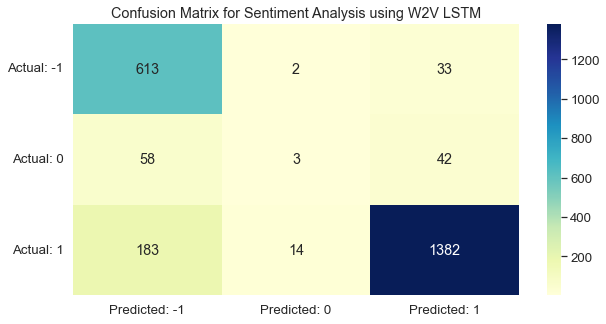

Confusion Matrix for Sentiment Analysis using W2V LSTM: 0.8575107296137339
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using W2V LSTM:

               precision    recall  f1-score   support

           0       0.72      0.95      0.82       648
           1       0.16      0.03      0.05       103
           2       0.95      0.88      0.91      1579

    accuracy                           0.86      2330
   macro avg       0.61      0.62      0.59      2330
weighted avg       0.85      0.86      0.85      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 94.59876543209876 %

Neutral has a accuracy of 2.912621359223301 %

Positive has a accuracy of 87.52374920835973 %


In [61]:
unseen_lstm_Y_test = pd.get_dummies(unseen_Y_test)
sequences_test = tokenizer.texts_to_sequences(unseen_X_test)
unseen_X_test = pad_sequences(sequences_test, maxlen=1000)
pred = w2v_lstm_model.predict(unseen_X_test)

y_true, y_pred = get_true_pred(pred, unseen_lstm_Y_test.values)
plot_confusion_matrix(y_true, y_pred, "W2V LSTM")

# Glove Embeddings

In [62]:

def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    word_to_vec_map = {}
    for line in f:
      w_line = line.split(' ')
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype='float32')

    return word_to_vec_map

In [63]:
word_to_vec_map = read_glove_vector('glove.6B/glove.6B.50d.txt')

In [64]:
emb_matrix = np.zeros((vocab_size, 50))

print(emb_matrix.shape)
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index] = embedding_vector

glove_embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights = [emb_matrix], trainable=False)


(23149, 50)


In [65]:
glove_lstm_model = model_architecture(glove_embedding_layer)
glove_lstm_model.fit(X_train_seq, Y_lstm_train,
                batch_size=32,
                epochs=10,
                validation_data=(x_test_indices, y_lstm_test),
                verbose=1,
                callbacks=early_stopping)

Epoch 1/10
381/381 [==============================] - 31s 78ms/step - loss: 0.5632 - accuracy: 0.7490 - val_loss: 0.4932 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 2/10
381/381 [==============================] - 30s 79ms/step - loss: 0.4867 - accuracy: 0.7938 - val_loss: 0.4191 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 3/10
381/381 [==============================] - 31s 82ms/step - loss: 0.4504 - accuracy: 0.8133 - val_loss: 0.4205 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 4/10
381/381 [==============================] - 29s 77ms/step - loss: 0.4358 - accuracy: 0.8216 - val_loss: 0.3929 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 5/10
381/381 [==============================] - 31s 82ms/step - loss: 0.4266 - accuracy: 0.8265 - val_loss: 0.4702 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 6/10
381/381 [==============================] - 27s 72ms/step - loss: 0.4080 - accuracy: 0.8403 - val_loss: 0.4126 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 7/10
381/381 [==============================] - 29s 

73/73 [==============================] - 3s 35ms/step
0
[0.95995903 0.00312792 0.0369131 ]
1
[0.75063914 0.04809121 0.20126964]
2
[0.9846294  0.00440746 0.01096316]
3
[0.84917265 0.03805558 0.11277168]
4
[0.827978   0.02458321 0.14743882]
5
[9.9740845e-01 3.5006137e-04 2.2415596e-03]
6
[0.98222303 0.00281936 0.01495754]
7
[0.99332535 0.00189559 0.00477904]
8
[0.9771643  0.0057155  0.01712007]
9
[0.90263754 0.00769901 0.08966344]
10
[0.85269326 0.03597846 0.11132829]
11
[0.99203295 0.00101419 0.00695286]
12
[0.92182547 0.00462799 0.07354657]
13
[0.98571235 0.00201369 0.01227393]
14
[0.94856405 0.0164195  0.03501641]
15
[0.9934228  0.00134933 0.00522791]
16
[0.8409568  0.02096633 0.13807681]
17
[0.95553434 0.00641944 0.03804624]
18
[9.9931324e-01 1.3549697e-04 5.5130158e-04]
19
[0.88412184 0.0065963  0.10928191]
20
[0.2974385  0.04309076 0.65947074]
21
[0.98694265 0.00988029 0.0031771 ]
22
[9.9931145e-01 2.7165550e-04 4.1692646e-04]
23
[0.77661556 0.05385001 0.16953455]
24
[0.92449105 0.

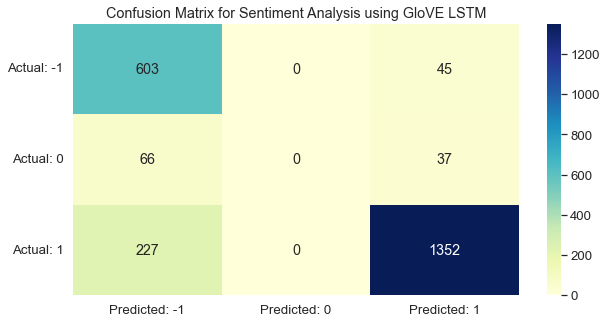

Confusion Matrix for Sentiment Analysis using GloVE LSTM: 0.8390557939914163
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using GloVE LSTM:

               precision    recall  f1-score   support

           0       0.67      0.93      0.78       648
           1       0.00      0.00      0.00       103
           2       0.94      0.86      0.90      1579

    accuracy                           0.84      2330
   macro avg       0.54      0.60      0.56      2330
weighted avg       0.83      0.84      0.83      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 93.05555555555556 %

Neutral has a accuracy of 0.0 %

Positive has a accuracy of 85.623812539582 %


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [66]:
pred = glove_lstm_model.predict(unseen_X_test)
y_true, y_pred = get_true_pred(pred, unseen_lstm_Y_test.values)
plot_confusion_matrix(y_true, y_pred, "GloVE LSTM")

## Doc2Vec

In [67]:
# # Get the vectors for every document
# X_train_d2v_seq = np.array([model_doc2vec.infer_vector(doc) for doc in X_train_tok])
# x_test_d2v_seq = [model_doc2vec.infer_vector(doc) for doc in x_test_tok]
# unseen_X_test_d2v = [model_doc2vec.infer_vector(doc) for doc in unseen_X_test_tok]

# print(X_train_d2v_seq.shape)

In [68]:
# # Creating a LSTM Model 
# # Dropout is use to prevent the model from overfitting
# d2v_LSTM_model = Sequential()
# d2v_LSTM_model.add(Dense(128, activation='relu', input_dim=X_train_d2v_seq.shape[1]))
# d2v_LSTM_model.add(Dropout(0.5))
# d2v_LSTM_model.add(CuDNNLSTM(100))
# d2v_LSTM_model.add(Dense(3, activation='softmax'))
# d2v_LSTM_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
# d2v_LSTM_model.fit(X_train_d2v_seq, Y_lstm_train,
#                 batch_size=32,
#                 epochs=10,
#                 validation_data=(x_test_d2v_seq, y_lstm_test),
#                 verbose=1,
#                 callbacks=early_stopping)

## Model Comparison

In [70]:
naive_bayes_model = [naive_bayes_tfidf_score, naive_bayes_Word2Vec_score, naive_bayes_Doc2Vec_score]
linear_svc_model = [Linear_SVC_tfidf_score, Linear_SVC_Word2Vec_score, Linear_SVC_Doc2Vec_score]
logistic_regression_model = [Logistic_Regression_tfidf_score, Logistic_Regression_Word2Vec_score, Logistic_Regression_Doc2Vec_score]


unseen_naive_bayes_model = [unseen_naive_bayes_tfidf_score, unseen_naive_bayes_Word2Vec_score, unseen_naive_bayes_Doc2Vec_score]
unseen_linear_svc_model = [unseen_Linear_SVC_tfidf_score, unseen_Linear_SVC_Word2Vec_score, unseen_Linear_SVC_Doc2Vec_score]
unseen_logistic_regression_model = [unseen_Logistic_Regression_tfidf_score, unseen_Logistic_Regression_Word2Vec_score, unseen_Logistic_Regression_Doc2Vec_score]

In [71]:
def comparing_models(naive_bayes, linear_svc, logistic_regression):
    fig, axes =plt.subplots(1,3, figsize=(20,20))
    # Bag of Words classifiers
    classifiers = ["TFIDF", "Word2Vec", "Doc2Vec"]

    color_discrete_map=['red', 'yellow', 'blue']
    accuracy = naive_bayes
    axes[0].set_title("Naive Bayes")
    axes[0].set_xlabel('Text Representation')
    axes[0].set_ylabel('TF-IDF Accuracy')
    axes[0].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


    accuracy =  linear_svc
    axes[1].set_title('Linear SVC')
    axes[1].set_xlabel('Text Representation')
    axes[1].set_ylabel('Accuracy')
    axes[1].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


    accuracy = logistic_regression
    axes[2].set_title('Logistic Regression')
    axes[2].set_xlabel('Text Representation')
    axes[2].set_ylabel(' Accuracy')
    axes[2].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)
    plt.show()


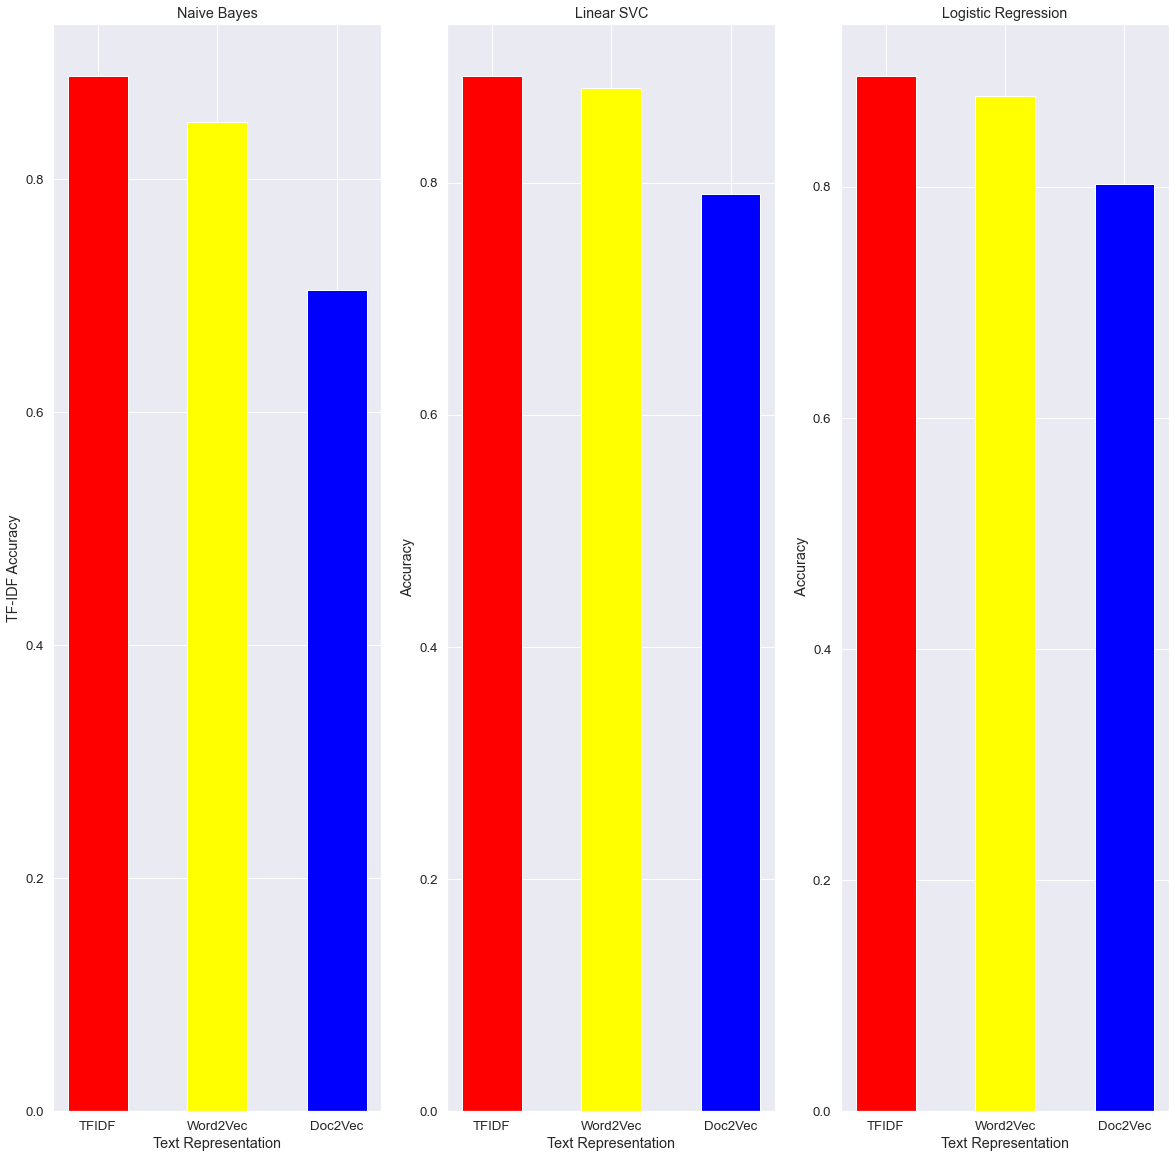

In [72]:
comparing_models(naive_bayes_model, linear_svc_model, logistic_regression_model)

# Ensemble Learning